In [1]:
import matplotlib.pyplot as plt
from astropy.wcs import WCS
from astropy.io import fits
import numpy as np
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils.aperture import CircularAperture
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.table import QTable
from astropy.coordinates import Angle
from photutils.aperture import EllipticalAperture


hdu = fits.open('ms_SIN_BL_400.fits')[0]
wcs = WCS(hdu.header)
image_data = hdu.data

wcs.world_axis_physical_types  

Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


['pos.eq.ra', 'pos.eq.dec', 'em.freq', 'phys.polarization.stokes']

In [2]:
# Método DAOstarfinder
from astropy.stats import sigma_clipped_stats

mean, median, std = sigma_clipped_stats(image_data[0][0], sigma=5.0)  
#print((mean, median, std))  

from photutils.detection import DAOStarFinder

daofind = DAOStarFinder(fwhm=3.0, threshold=5.*std)  
sources = daofind(image_data[0][0] - median) 

for col in sources.colnames:  
    sources[col].info.format = '%.8g'  # for consistent table output

In [3]:
#Convierto de pixeles a las coordenadas reales de las fuentes
#Selecciono las coordenadas en píxeles de cada fuente en un array
xcentroid = np.array(sources['xcentroid'])
ycentroid = np.array(sources['ycentroid'])
ceros = np.zeros(len(xcentroid))

#wcs.wcs_pix2world(x,y,freq,stokes,origin)
ra, dec = wcs.all_pix2world(xcentroid,ycentroid,ceros,ceros,1,ra_dec_order=True)

#Arreglo de coordenadas para poder realizar la conversión de deg a hms

coords = SkyCoord(ra*u.degree, dec*u.degree)

RA = []
for i in range(len(ra)):
    r = list(coords.ra[i].hms)
    RA += [r]

peak = np.array(sources['peak'])
flux = np.array(sources['flux'])

id_ = np.arange(0,74)

#Creo una tabla de astropy con los valores de interés 

names=['Ascención recta', 'Declinación', 'Peak', 'Flux', 'ID']

# Coords reales en hms
S_hms = QTable([RA,coords.dec,peak,flux,id_], names=names)

# Coords en pixeles
S_pix = QTable([xcentroid,ycentroid,peak,flux,id_], names=names)

# Coords reales en degree
S_degree = QTable([coords.ra,coords.dec,peak,flux,id_], names=names)

In [4]:
#Parametros de las aperturas para cada fuente puntual

a = 43.97

b = 29.06

theta = Angle(-9.90377, 'deg')

positions = np.transpose((S_pix['Ascención recta'], S_pix['Declinación']))
#apertures = EllipticalAperture(positions,a=a, b=b, theta=theta)
apertures = CircularAperture(positions, r=4.)
norm = ImageNormalize(stretch=SqrtStretch())

<function matplotlib.pyplot.show(close=None, block=None)>

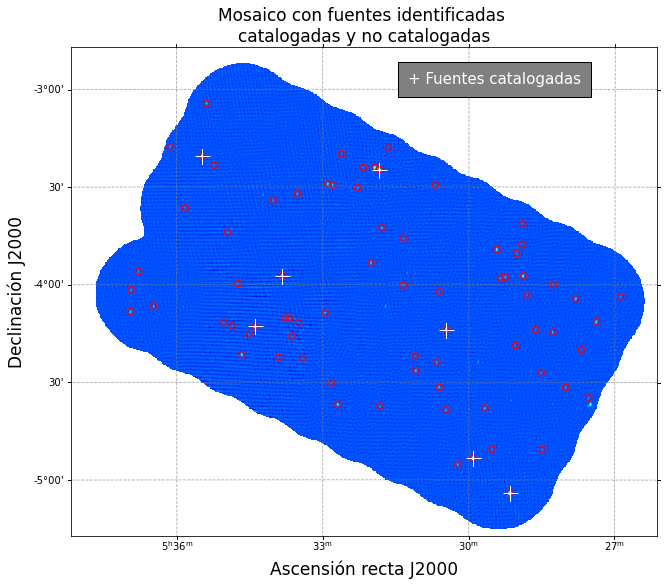

In [5]:
# Selecciones solo las fuentes puntuales del mosaico
fig=plt.figure(figsize=(10.5,10.5))
ax=fig.gca()

ax = plt.subplot(projection=wcs, slices=('x', 'y', 0,0))
ax.imshow(image_data[0][0], cmap='jet', origin='lower', norm=norm)
apertures.plot(color='red', lw=1.5, alpha=0.8)
ax.grid(color='grey', ls='--', alpha=0.7)
ax.plot(276.48203512966467, 406.9093375372213,'+w', ms=15) 
ax.plot(210.92282313067574,616.279241397515,'+w', ms=15) 
ax.plot(309.3454509981666,469.50497394506476,'+w', ms=15) 
ax.plot(428.52376837848067,599.8253943269401,'+w', ms=15)
ax.plot(543.743013249093,245.1141938291162,'+w', ms=15) 
ax.plot(589.2681698653868,202.42401456593964,'+w', ms=15)
ax.plot(510.71694785664437,403.19825979632986,'+w', ms=15)

#ax.legend(fontsize='15')
ax.set_xlabel('Ascensión recta J2000', fontsize='17')
ax.set_ylabel('Declinación J2000', fontsize='17')
ax.set_title('''Mosaico con fuentes identificadas 
catalogadas y no catalogadas''', fontsize='17')
ax.set_xlim(50,770)
ax.set_ylim(150,750)
ax.text(570,720,"+ Fuentes catalogadas",
         fontsize=15,
         color="white",
         verticalalignment ='top', 
         horizontalalignment ='center',
         bbox ={'facecolor':'grey', 
                'pad':10}       )  
plt.show
#plt.savefig('resultado')

In [6]:
lista_ra = []
pixeles = []
for i in range(len(S_hms)):
    lista_ra.append([S_hms[i][0], i])
    pixeles += [S_pix[i][0], S_pix[i][1]]
    
    
a, b= 5, 34
for i in range(len(lista_ra)):
    if lista_ra[i][0][0]==a and lista_ra[i][0][1]==b:
        print(lista_ra[i])

[array([ 5.        , 34.        , 40.47630636]), 19]
[array([ 5.       , 34.       , 31.8265823]), 23]
[array([ 5.        , 34.        , 52.36429583]), 27]
[array([ 5.        , 34.        , 23.85633746]), 28]
[array([ 5.        , 34.        , 45.33391852]), 44]
[array([ 5.        , 34.        , 57.91919953]), 55]
[array([ 5.        , 34.        ,  1.90505201]), 59]


In [7]:
n = 19
print(S_pix[n][0],',', S_pix[n][1])
print(S_hms[n][0],',',S_hms[n][1])

259.9325072917131 , 372.30656336932805
[ 5.         34.         40.47630636] , -4d21m46.73026902s


In [8]:
#S_pix.show_in_notebook(display_length=100)

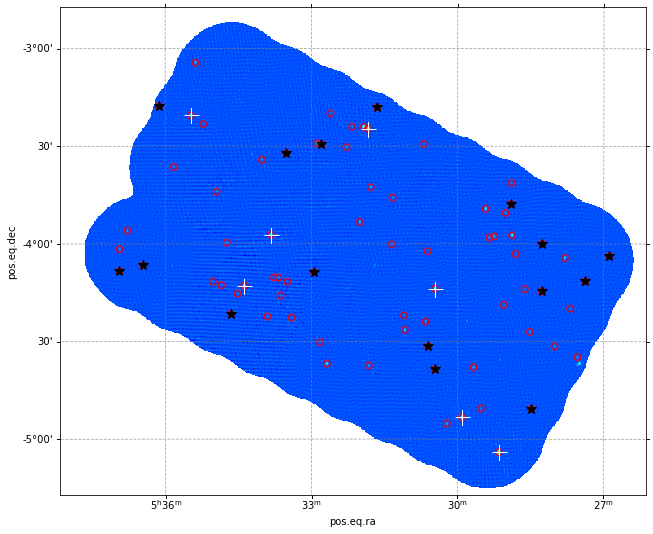

In [9]:
fig=plt.figure(figsize=(10.5,10.5))
ax=fig.gca()

ax = plt.subplot(projection=wcs, slices=('x', 'y', 0,0))
ax.imshow(image_data[0][0], cmap='jet', origin='lower', norm=norm)
apertures.plot(color='red', lw=1.5, alpha=0.8)
ax.grid(color='grey', ls='--', alpha=0.7)
ax.plot(276.48203512966467, 406.9093375372213,'+w',ms=15)#28 
ax.plot(309.3454509981666,469.50497394506476,'+w',ms=15)#48 
ax.plot(428.52376837848067,599.8253943269401,'+w',ms=15)#65
ax.plot(543.743013249093,245.1141938291162,'+w', ms=15)#2 
ax.plot(589.2681698653868,202.42401456593964,'+w', ms=15)#0
ax.plot(510.71694785664437,403.19825979632986,'+w', ms=15)#25
ax.plot(210.92282313067574,616.279241397515,'+w', ms=15)#69


ax.plot(629.1736382381606, 255.76972962572788,'*k',ms=10)
ax.plot(510.6254758724604, 304.4079694374183,'*k',ms=10)
ax.plot(502.3727608383887, 332.40871698536085,'*k',ms=10)
ax.plot(641.9046744794127, 399.91357215091875,'*k',ms=10)
ax.plot(695.5220126504613, 412.6095141019946,'*k',ms=10)
ax.plot(362.0045295780095, 423.7865362482009,'*k',ms=10)
ax.plot(122.89172799920111 , 424.9510779629151,'*k',ms=10)
ax.plot(151.4884207421199 , 431.9466748519073,'*k',ms=10)
ax.plot(642.5724467224961 , 458.43285978358585,'*k',ms=10)
ax.plot(604.0500474971623 , 507.72445665662144,'*k',ms=10)
ax.plot(327.98996714154936 , 569.7473266948501,'*k',ms=10)
ax.plot(371.39293204134384 , 580.9665916869002,'*k',ms=10)
ax.plot(439.8845756300861 , 626.1537651251189,'*k',ms=10)
ax.plot(725.2534239757076 , 443.48313264155473,'*k',ms=10)
ax.plot(171.77565533862906 , 627.7882974522497,'*k',ms=10)
ax.plot(259.9325072917131 , 372.30656336932805,'*k',ms=10)



ax.set_xlim(50,770)
ax.set_ylim(150,750);

In [10]:
#S_pix.show_in_notebook(display_length=100)

In [11]:
#Removemos de la tabla las fuentes ya catalogadas en el mosaico anterior 
S_pix.remove_rows([4,5,10,24,31,34,35,36,43,53,60,62,71,9,72,42,19,69,28,48,65,2,0,25])
S_hms.remove_rows([4,5,10,24,31,34,35,36,43,53,60,62,71,9,72,42,19,69,28,48,65,2,0,25])
S_degree.remove_rows([4,5,10,24,31,34,35,36,43,53,60,62,71,9,72,42,19,69,28,48,65,2,0,25])

In [27]:
43.968*0.15

6.5952

In [12]:
#Parametros de las aperturas para cada fuente puntual

a = 43.97

b = 29.06

theta = Angle(90-5.17261,'deg')

positions = np.transpose((S_pix['Ascención recta'], S_pix['Declinación']))
apertures = EllipticalAperture(positions,a=0.15*a, b=0.15*b, theta=theta)
norm = ImageNormalize(stretch=SqrtStretch())

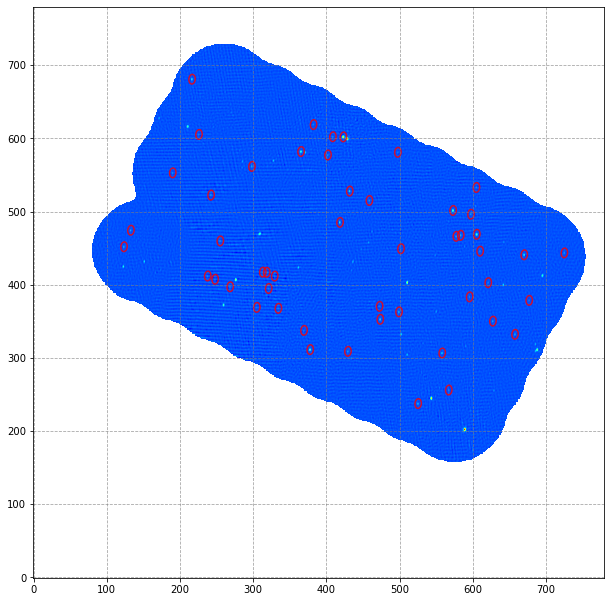

In [13]:
fig=plt.figure(figsize=(10.5,10.5))
ax=fig.gca()

ax = plt.subplot()
ax.imshow(image_data[0][0], cmap='jet', origin='lower', norm=norm)
apertures.plot(color='red', lw=1.5, alpha=0.8)
ax.grid(color='grey', ls='--', alpha=0.7)


#plt.savefig("fuentes_nuevas.jpg",dpi=420,bbox_inches='tight')

In [14]:
#S_hms.write('example_isolist_tab.ecsv')

In [15]:
right_casa = []
dec_casa = []
bma = list(34.9721 for i in range(50))
bmia = list(20.0587 for i in range(50))
ang = list(0 for i in range(50))
for k in range(50):
    right_casa +=[S_degree[k][0]]
    dec_casa += [S_degree[k][1]]
    
#Creo una tabla de astropy para las aperturas del tamaño del beam para abrir en CASA

names=['x', 'y', 'BMIA', 'BMA', 'i']

# aperturas con el beam restaurado del mosaico 
beam_aper = QTable([right_casa,dec_casa,bmia,bma,ang], names=names)

In [16]:
beam_aper.write('beam_aper.ecsv')